In [8]:
import torch
import torch_geometric
from torch_geometric.data import Data
import networkx as nx

In [83]:
def create_graphs():
    nx_graphs = [
        nx.grid_2d_graph(i, j)
        for i in range(2, 4)
        for j in range(2, 4)
    ]
    # convert to torch_geometric format
    return nx_graphs
    #return list(map(torch_geometric.utils.from_networkx, nx_graphs))
graphs = create_graphs()
graphs
    

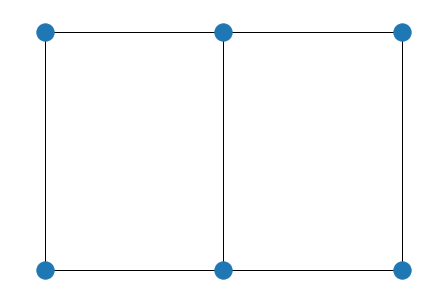

In [89]:
#draw the graph
nx.draw_spectral(graphs[1])

In [66]:
from graphrnn import data

In [64]:
%cd ../../

/home/orausch/sources/graphrnn


In [86]:
c

In [87]:
sampler[0]

{'x': array([[1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 'y': array([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 'len': 4}

In [136]:
G = nx.Graph()
G

In [137]:
G.add_nodes_from([1, 2, 3, 4, 5])

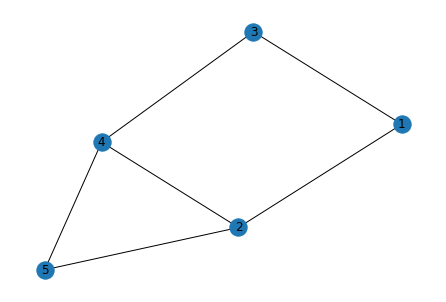

In [140]:
G.add_edges_from([(1, 3), (1, 2), (2, 4), (4, 5), (2, 5), (3, 4)])
nx.draw(G, with_labels=True)

In [139]:
sampler = data.GraphSequenceSampler([G], max_prev_node=2)
adj = nx.to_numpy_array(G)
torch_geometric.utils.from_networkx(G).edge_index

tensor([[0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4],
        [2, 1, 0, 3, 4, 0, 3, 1, 2, 4, 1, 3]])

In [114]:
data.encode_adj(adj, max_prev_node=2)

array([[1., 0.],
       [0., 1.],
       [1., 1.],
       [1., 1.]])

In [248]:
class BFS(T.BaseTransform):
    """
    Start a breath first search from a random node and reorder the edge list so
    that the node indices correspond to the breadth-first search order.
    """
    def __call__(self, data):
        x = data.x
        edge_index = data.edge_index
        assert data.is_undirected(), 'Transform only works for undirected graphs.'
        G = torch_geometric.utils.to_networkx(data, to_undirected=data.is_undirected())

        start_node = torch.randint(0, data.num_nodes, (1,)).item()

        # get the breadth-first search order
        bfs_order = [start_node] + [n for _, n in nx.bfs_edges(G, start_node)]
        perm = torch.tensor(bfs_order).argsort()

        return torch_geometric.data.Data(x=x, edge_index=perm[edge_index], num_nodes=data.num_nodes)

    def __repr__(self):
        return '{}'.format(self.__class__.__name__)

def encode_bfs_adjacency(data, M):
    """
    Given a pytorch geometric graph `data`, order the nodes according to a BFS started at a random node.

    Then, for each node n compute a new feature x:
    This is a fixed M-dimensional vector, representing the connectivity between
    node n and nodes in the current BFS queue.
    M is a given (possibly emperical) bound on the maximum size of the queue of this BFS. 
    """
    #G = torch_geometric.utils.to_networkx(data)
    G = data
    # get a random start node
    # start_node = torch.randint(0, data.num_nodes, (1,)).item()
    start_node = 1

    num_nodes = G.number_of_nodes() + 1
    x = torch.zeros((num_nodes, M))
    for source, dest in nx.bfs_edges(G, start_node):
        if source - M >= 0:
            x[source, dest] = 1
    return x




In [249]:
data = torch_geometric.utils.from_networkx(G)
data.is_undirected()
draw_data = lambda data: nx.draw_spectral(torch_geometric.utils.to_networkx(data), with_labels=True)

tensor([[0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4],
        [2, 1, 0, 3, 4, 0, 3, 1, 2, 4, 1, 3]])


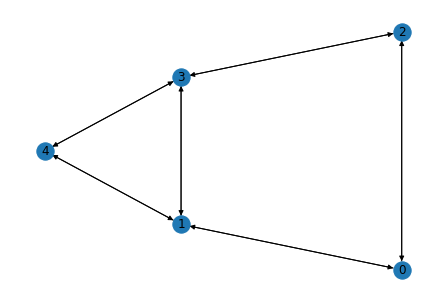

In [250]:

draw_data(data)
print(data.edge_index)

tensor([[1, 1, 0, 0, 0, 4, 4, 2, 2, 2, 3, 3],
        [4, 0, 1, 2, 3, 1, 2, 0, 4, 3, 0, 2]])


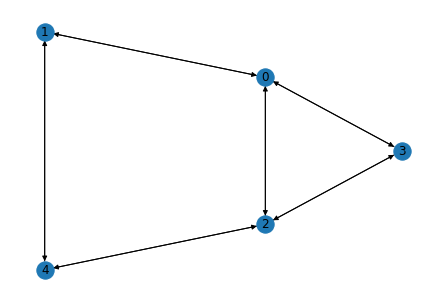

In [251]:
out_data = BFS()(data)
print(out_data.edge_index)
draw_data(out_data)

In [252]:
class EncodeGraphRNNFeature(T.BaseTransform):
    def __init__(self, M):
        self.M = M

    def __call__(self, data):
        x = data.x
        edge_index = data.edge_index
        num_nodes = data.num_nodes
        # add the graph rnn feature
        x = torch.cat([x, encode_bfs_adjacency(data, self.M)], dim=1)
        return torch_geometric.data.Data(x=x, edge_index=edge_index, num_nodes=num_nodes)

def banded_view(adj, M):
    """
    Uses stride tricks to return a view of adj containing the 
    :param adj: dimension N x N
    :param M: number of bands above the diagonal to return
    :result: dimension N x M; the M bands above the diagonal
    """
    adj = adj.contiguous()
    N = adj.shape[0]
    return adj.as_strided(shape=(N, M), strides=(N, 1))


def encode_adj(adj, max_prev_node=10, is_full = False):
    '''

    :param adj: n*n, rows means time step, while columns are input dimension
    :param max_degree: we want to keep row number, but truncate column numbers
    :return:
    '''
    if is_full:
        max_prev_node = adj.shape[0]-1

    # pick up lower tri
    adj = np.tril(adj, k=-1)
    n = adj.shape[0]
    adj = adj[1:n, 0:n-1]

    # use max_prev_node to truncate
    # note: now adj is a (n-1)*(n-1) matrix
    adj_output = np.zeros((adj.shape[0], max_prev_node))
    for i in range(adj.shape[0]):
        input_start = max(0, i - max_prev_node + 1)
        input_end = i + 1
        output_start = max_prev_node + input_start - input_end
        output_end = max_prev_node
        adj_output[i, output_start:output_end] = adj[i, input_start:input_end]
        adj_output[i,:] = adj_output[i,:][::-1] # reverse order

    return adj_output

def decode_adj(adj_output):
    '''
        recover to adj from adj_output
        note: here adj_output have shape (n-1)*m
    '''
    max_prev_node = adj_output.shape[1]
    adj = np.zeros((adj_output.shape[0], adj_output.shape[0]))
    for i in range(adj_output.shape[0]):
        input_start = max(0, i - max_prev_node + 1)
        input_end = i + 1
        output_start = max_prev_node + max(0, i - max_prev_node + 1) - (i + 1)
        output_end = max_prev_node
        adj[i, input_start:input_end] = adj_output[i,::-1][output_start:output_end] # reverse order
    adj_full = np.zeros((adj_output.shape[0]+1, adj_output.shape[0]+1))
    n = adj_full.shape[0]
    adj_full[1:n, 0:n-1] = np.tril(adj, 0)
    adj_full = adj_full + adj_full.T

    return adj_full

In [241]:
_, indices = torch.sort(out_data.edge_index[0])
edge_index_sorted = out_data.edge_index[:, indices]

In [242]:
edge_index_sorted

tensor([[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4],
        [1, 2, 3, 2, 0, 1, 4, 0, 4, 1, 3, 2]])

In [243]:
out_data.edge_index

tensor([[3, 3, 1, 1, 1, 4, 4, 2, 2, 2, 0, 0],
        [4, 1, 3, 2, 0, 3, 2, 1, 4, 0, 1, 2]])

In [256]:
list(nx.bfs_edges(G, 1))

[(1, 3), (1, 2), (3, 4), (2, 5)]

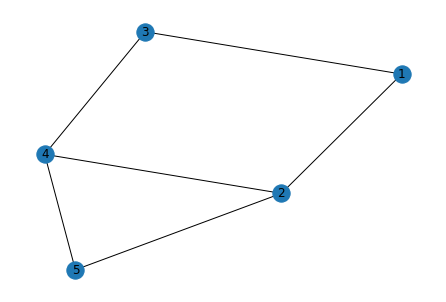

In [259]:
nx.draw(G, with_labels=True)